# Ejemplo de uso de los datos de Santa Maria y Stanford

El archivo muestra las siguientes funciones:
1. Cargar datos *tensorflow* de Santa María y Stanford.
2. Dividir datos en entrenamiento y testeo con las clases balanceadas y para un valor de división deseada.
3. Visualizar imágenes de **PET**, **Body CT** y **Torax3d**
Se muestra un ejemplo de uso de carga de los datos de santa maría y Stanford.

**IMPORTANTE**: Se deben descargar los datos de Santa María y de Stanford de la forma en que se indica en el README. Es necesario haber instalado *tensorflow* y *tensorflow_datasets* como se indica en el readme también para cargar los datos.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import resource
import tensorflow_datasets as tfds
import random
import pandas as pd
from tqdm import trange
import csv
import os
from pathlib import Path
import nrrd
import pydicom
from PIL import Image
import numpy as np


/home/roberto/anaconda3/envs/lung_radiomics/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [32]:
patients = range(0, 155)
data_type = 'chest_ct'
segmentation_dcm_list = []

for i in patients:
    if i<10: patient_id = f'R01-00{i}'
    elif i<100: patient_id = f'R01-0{i}'
    else: patient_id = f'R01-{i}'
    exam_results = os.path.join('/media/roberto/TOSHIBA EXT/pet_ct/stanford_data/data/', patient_id, data_type)
    if os.path.exists(exam_results):
        mask_path = os.path.join('/media/roberto/TOSHIBA EXT/pet_ct/stanford_data/data/', patient_id, data_type, f'{patient_id}_{data_type}_segmentation')
        if not os.path.exists(mask_path + '.nrrd') and os.path.exists(mask_path + '.dcm'):
            print(patient_id)
            segmentation_dcm_list.append(patient_id)
print(len(segmentation_dcm_list))

R01-001
R01-002
R01-012
R01-014
R01-015
R01-025
R01-027
R01-028
R01-029
R01-030
R01-031
R01-032
R01-033
R01-034
R01-035
R01-036
R01-037
R01-039
R01-040
R01-041
R01-042
R01-043
R01-044
R01-045
R01-046
R01-047
R01-048
R01-049
R01-050
R01-051
R01-052
R01-053
R01-054
R01-055
R01-056
R01-058
R01-059
R01-060
R01-061
R01-062
R01-063
R01-064
R01-065
R01-066
R01-067
R01-068
R01-069
R01-070
R01-071
R01-072
R01-073
R01-074
R01-075
R01-077
R01-079
R01-080
R01-081
R01-082
R01-083
59


/home/roberto/Desktop/lung_radiomics/pet_ct
/home/roberto/Desktop/lung_radiomics/pet_ct/santa_maria_ds/santa_maria_data/EGFR+/pet/image/sm_006_pet_image.nrrd
(144, 144, 276) (144, 144, 276)


100%|██████████████████████████████████████| 276/276 [00:00<00:00, 32848.89it/s]

(144, 144, 19) (144, 144, 19)
float32 uint16
0.0 41900.89 0 1


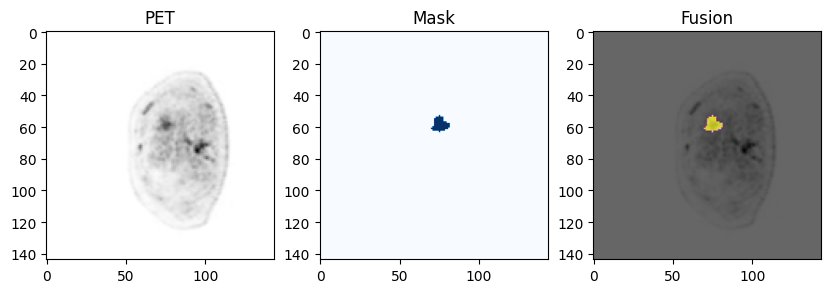

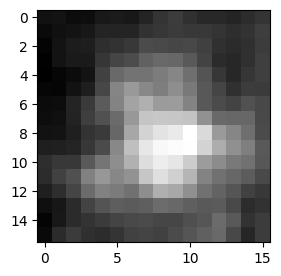

In [53]:
import cv2

# Carpeta donde la data se encuentra
patient_id = 'AMC-044'
data_type = 'chest_ct'
mask_type = 'chest_ct'

print(os.getcwd())
data_path = os.path.join(os.getcwd(),'santa_maria_ds/santa_maria_data/EGFR+/pet/image/sm_006_pet_image.nrrd')
mask_path = os.path.join(os.getcwd(),'santa_maria_ds/santa_maria_data/EGFR+/pet/label/sm_006_pet_segmentation.nrrd')

print(data_path)
#data_path = os.path.join('/media/roberto/TOSHIBA EXT/pet_ct/stanford_data/data/', patient_id, data_type, f'{patient_id}_{data_type}_image.nrrd')
#data_path_2 = os.path.join('/media/roberto/TOSHIBA EXT/pet_ct/stanford_data/data/', patient_id, mask_type, f'{patient_id}_{mask_type}_image.nrrd')
#mask_path = os.path.join('/media/roberto/TOSHIBA EXT/pet_ct/stanford_data/data/', patient_id, mask_type, f'{patient_id}_{mask_type}_segmentation.dcm')
#mask_path = os.path.join('/media/roberto/TOSHIBA EXT/pet_ct/stanford_data/data/', patient_id, mask_type, f'{patient_id}_{mask_type}_segmentation.nrrd')

data_exam, _= nrrd.read(data_path)
#data_exam_2, _= nrrd.read(data_path_2)

mask_exam, _= nrrd.read(mask_path)

#mask_exam = pydicom.dcmread(mask_path).pixel_array
#mask_exam = np.moveaxis(mask_exam, 0, 2)

print(data_exam.shape, mask_exam.shape)


def roiExtractionSize(img_instance, mask_instance, total_size):
    """
    Function to extract ROIs from images while ensuring a consistent total size for all ROIs.

    INPUT:
    img: Numpy array of images.
    mask: Numpy array of masks.
    total_size: The desired total size (width and height) of the extracted ROIs.

    OUTPUT: Numpy array containing the ROIs.
    """
    
    index = np.where(mask_instance)

    # Calculate the center of the mask.
    center_row = int(np.mean(index[0]))
    center_col = int(np.mean(index[1]))

    # Calculate the size of the ROI based on the total size.
    half_size = total_size // 2

    # Determine ROI boundaries with the margin.
    min_row = max(0, center_row - half_size)
    max_row = min(mask_instance.shape[0], center_row + half_size)
    min_col = max(0, center_col - half_size)
    max_col = min(mask_instance.shape[1], center_col + half_size)

    # Calculate the width and height of the ROI.
    roi_height = max_row - min_row
    roi_width = max_col - min_col

    # Case 1: If the ROI is smaller than the total_size, add a margin to make it total_size.
    if roi_height < total_size:
        margin = (total_size - roi_height) // 2
        min_row -= margin
        max_row += margin

    if roi_width < total_size:
        margin = (total_size - roi_width) // 2
        min_col -= margin
        max_col += margin

    # Case 2: If the ROI is larger than total_size, resize it.
    if roi_height > total_size or roi_width > total_size:
        scale_factor = total_size / max(roi_height, roi_width)
        new_height = int(roi_height * scale_factor)
        new_width = int(roi_width * scale_factor)
        min_row = max(center_row - new_height // 2, 0)
        max_row = min(min_row + new_height, mask_instance.shape[0])
        min_col = max(center_col - new_width // 2, 0)
        max_col = min(min_col + new_width, mask_instance.shape[1])

    # Extract the ROI with the desired size.
    roi = img_instance[min_row:max_row, min_col:max_col]

    return roi
    
def visualizeImgMask(img, mask, pet):
    """
    Función para visualizar las imágenes, máscaras y fusión.
    INPUT: imágenes y máscaras como numpy array 3D (numero de imagenes, alto, ancho),
    PET: True or False. Si es True se visualiza en inverso (cmap=gray_r),
    solo por un tema de convención de la visualización del PET.
    """

    # Scale the int16 image to uint8 range (0-255)
    img = ((img - np.min(img)) / (np.max(img) - np.min(img)) * 255).astype(np.uint8)
    
    # Scale the mask to uint8 range
    mask = ((mask - np.min(mask)) / (np.max(mask) - np.min(mask)) * 255).astype(np.uint8)

    img_pil = Image.fromarray(img)
    mask_pil = Image.fromarray(mask)

    if pet:
        f, axarr = plt.subplots(1, 3, figsize=(10, 10))
        axarr[0].set_title("PET")
        axarr[0].imshow(img_pil, cmap='gray_r')
        axarr[1].set_title("Mask")
        axarr[1].imshow(mask_pil, cmap='Blues')
        axarr[2].set_title("Fusion")
        axarr[2].imshow(img_pil, cmap='gray_r')
        axarr[2].imshow(mask_pil, cmap='gnuplot', alpha=0.6)
        plt.show()

    else:
        f, axarr = plt.subplots(1, 3, figsize=(10, 10))
        axarr[0].set_title("CT")
        axarr[0].imshow(img_pil, cmap='gray')
        axarr[1].set_title("Mask")
        axarr[1].imshow(mask_pil, cmap='Blues')
        axarr[2].set_title("Fusion")
        axarr[2].imshow(img_pil, cmap='gray')
        axarr[2].imshow(mask_pil, cmap='gnuplot', alpha=0.6)
        plt.show()

def show_slice_window(slice, level, window):

    """
    Permite ajustar nivel y ancho de ventana para mejorar contraste de la imagen.
    input: imagen np.array 2D.
    output: imagen np.array 2D ajustada.
   """
    max = level + window/2
    min = level - window/2
    slice = slice.clip(min,max)
    return(slice)

def roiExtraction (img,mask,margin):
    """
  Función para extraer el ROI donde se encuentra el tumor en una imagen.
  INPUT: imagen y máscaras numpy array 2D.
  margin: corresponde al número de pixeles como margen por fuera de los pixeles de la máscara.
  OUTPUT: Devuelve el ROI.
  """

    roi_extract = []

    index = np.where(mask)
    roi = img[np.unique(index[0])[0]-margin:np.unique(index[0])[-1]+margin, np.unique(index[1])[0]-margin: np.unique(index[1])[-1]+margin]
    return roi


def extractImages(data_img, data_mask):

    """
  Función que extrae sólo las imágenes de los niveles que contienen segmentación.
  INPUT: volumen de imágenes y máscaras numpy array 3D (numero de imagen, alto, ancho), directo de la
  carga del archivo .nrrd.
  Busca las máscaras con segmentaciones y extrae los cortes de estos niveles.
  OUTPUT: devuelve np.array 3D con las imágenes y máscaras sólo de los niveles del tumor.
    """

    images = []
    masks = []
    positive_slices = []

    for i in trange(data_img.shape[2]):
        segmentation = data_mask[:,:,i]
        if (np.sum(segmentation)>0):
            positive_slices.append(i)

        ## Extrae las imágenes sólo con segmentación - tumor
    for axial in positive_slices:
        segment = data_mask[:,:,axial]
        ct = data_img[:,:,axial]
        images.append(ct)
        masks.append(segment)

    images = np.stack(images, axis=2)
    masks = np.stack(masks, axis=2)
    return(images, masks)

i_slice = 1
data_exam, mask_exam_new = extractImages(data_exam, mask_exam)
#data_exam_2, mask_exam_2 = extractImages(data_exam_2, mask_exam)

print(data_exam.shape, mask_exam_new.shape)
print(data_exam.dtype, mask_exam_new.dtype)
print(np.min(data_exam), np.max(data_exam), np.min(mask_exam_new), np.max(mask_exam_new))

data_exam_i = data_exam[:,:,i_slice]
mask_exam_new_i = mask_exam_new[:,:,i_slice]
#data_exam_i = np.rot90(data_exam[:,:,i_slice], k=3)
#data_exam_i = np.fliplr(data_exam_i)

# dcm files
#mask_exam_new_i = mask_exam_new[:,:,i_slice]

# nrrd files
#mask_exam_new_i = np.rot90(mask_exam_new[:,:,i_slice], k=3)
#mask_exam_new_i = np.fliplr(mask_exam_new_i)

visualizeImgMask(data_exam_i, mask_exam_new_i, pet=True)
#visualizeImgMask(data_exam[:,:,i_slice], mask_exam_new_i, pet=False


roi_exam_train = roiExtractionSize(data_exam_i, mask_exam_new_i, 16)

f = plt.figure(figsize=(3,6), frameon=True)
plt.imshow(roi_exam_train, cmap='gray')


# error: [1, 12]
# k=1: [2, ]
# k=2: []
# k=3: []

#visualizeImgMask(data_exam[:,:,i_slice], np.rot90(mask_exam_new[:,:,i_slice], k=3), pet=False)


#mask: always has one of two values (0 or 1) so can be replaced with int
#data: when comes from dcm data is int16 - chest_ct - so it can be replaced with float32
# when it comes from nrrd data is float32 - so it can be replaced with float32 

In [27]:
# se cargan los datos de santa maría y stanford
# Para el ejemplo se cargan los datos de los exámenes torax3d, se puede reemplazar con 'pet' o 'body'
sample_dataset, info = tfds.load('santa_maria_dataset/body', with_info=True)
stanford_dataset, stanford_info = tfds.load('stanford_dataset/ct', with_info=True)
#sample_dataset, info = tfds.load('santa_maria_dataset/pet', with_info=True)
#sample_dataset, info = tfds.load('santa_maria_dataset/body', with_info=True)

DatasetNotFoundError: Dataset stanford_dataset not found.
Available datasets:
	- abstract_reasoning
	- accentdb
	- aeslc
	- aflw2k3d
	- ag_news_subset
	- ai2_arc
	- ai2_arc_with_ir
	- amazon_us_reviews
	- anli
	- answer_equivalence
	- arc
	- asqa
	- asset
	- assin2
	- bair_robot_pushing_small
	- bccd
	- beans
	- bee_dataset
	- beir
	- big_patent
	- bigearthnet
	- billsum
	- binarized_mnist
	- binary_alpha_digits
	- ble_wind_field
	- blimp
	- booksum
	- bool_q
	- bucc
	- c4
	- c4_wsrs
	- caltech101
	- caltech_birds2010
	- caltech_birds2011
	- cardiotox
	- cars196
	- cassava
	- cats_vs_dogs
	- celeb_a
	- celeb_a_hq
	- cfq
	- cherry_blossoms
	- chexpert
	- cifar10
	- cifar100
	- cifar100_n
	- cifar10_1
	- cifar10_corrupted
	- cifar10_n
	- citrus_leaves
	- cityscapes
	- civil_comments
	- clevr
	- clic
	- clinc_oos
	- cmaterdb
	- cnn_dailymail
	- coco
	- coco_captions
	- coil100
	- colorectal_histology
	- colorectal_histology_large
	- common_voice
	- conll2002
	- conll2003
	- controlled_noisy_web_labels
	- coqa
	- cos_e
	- cosmos_qa
	- covid19
	- covid19sum
	- crema_d
	- criteo
	- cs_restaurants
	- curated_breast_imaging_ddsm
	- cycle_gan
	- d4rl_adroit_door
	- d4rl_adroit_hammer
	- d4rl_adroit_pen
	- d4rl_adroit_relocate
	- d4rl_antmaze
	- d4rl_mujoco_ant
	- d4rl_mujoco_halfcheetah
	- d4rl_mujoco_hopper
	- d4rl_mujoco_walker2d
	- dart
	- davis
	- deep1b
	- deep_weeds
	- definite_pronoun_resolution
	- dementiabank
	- diabetic_retinopathy_detection
	- diamonds
	- div2k
	- dmlab
	- doc_nli
	- dolphin_number_word
	- domainnet
	- downsampled_imagenet
	- drop
	- dsprites
	- dtd
	- duke_ultrasound
	- e2e_cleaned
	- efron_morris75
	- emnist
	- eraser_multi_rc
	- esnli
	- eurosat
	- fashion_mnist
	- flic
	- flores
	- food101
	- forest_fires
	- fuss
	- gap
	- geirhos_conflict_stimuli
	- gem
	- genomics_ood
	- german_credit_numeric
	- gigaword
	- glove100_angular
	- glue
	- goemotions
	- gov_report
	- gpt3
	- gref
	- groove
	- grounded_scan
	- gsm8k
	- gtzan
	- gtzan_music_speech
	- hellaswag
	- higgs
	- hillstrom
	- horses_or_humans
	- howell
	- i_naturalist2017
	- i_naturalist2018
	- i_naturalist2021
	- imagenet2012
	- imagenet2012_corrupted
	- imagenet2012_fewshot
	- imagenet2012_multilabel
	- imagenet2012_real
	- imagenet2012_subset
	- imagenet_a
	- imagenet_lt
	- imagenet_pi
	- imagenet_r
	- imagenet_resized
	- imagenet_sketch
	- imagenet_v2
	- imagenette
	- imagewang
	- imdb_reviews
	- irc_disentanglement
	- iris
	- istella
	- kddcup99
	- kitti
	- kmnist
	- laion400m
	- lambada
	- lfw
	- librispeech
	- librispeech_lm
	- libritts
	- ljspeech
	- lm1b
	- locomotion
	- lost_and_found
	- lsun
	- lvis
	- malaria
	- math_dataset
	- math_qa
	- mctaco
	- media_sum
	- mlqa
	- mnist
	- mnist_corrupted
	- movie_lens
	- movie_rationales
	- movielens
	- moving_mnist
	- mrqa
	- mslr_web
	- mt_opt
	- mtnt
	- multi_news
	- multi_nli
	- multi_nli_mismatch
	- natural_instructions
	- natural_questions
	- natural_questions_open
	- newsroom
	- nsynth
	- nyu_depth_v2
	- ogbg_molpcba
	- omniglot
	- open_images_challenge2019_detection
	- open_images_v4
	- openbookqa
	- opinion_abstracts
	- opinosis
	- opus
	- oxford_flowers102
	- oxford_iiit_pet
	- para_crawl
	- pass
	- patch_camelyon
	- paws_wiki
	- paws_x_wiki
	- penguins
	- pet_finder
	- pg19
	- piqa
	- places365_small
	- placesfull
	- plant_leaves
	- plant_village
	- plantae_k
	- protein_net
	- q_re_cc
	- qa4mre
	- qasc
	- quac
	- quality
	- quickdraw_bitmap
	- race
	- radon
	- reddit
	- reddit_disentanglement
	- reddit_tifu
	- ref_coco
	- resisc45
	- rlu_atari
	- rlu_atari_checkpoints
	- rlu_atari_checkpoints_ordered
	- rlu_control_suite
	- rlu_dmlab_explore_object_rewards_few
	- rlu_dmlab_explore_object_rewards_many
	- rlu_dmlab_rooms_select_nonmatching_object
	- rlu_dmlab_rooms_watermaze
	- rlu_dmlab_seekavoid_arena01
	- rlu_locomotion
	- rlu_rwrl
	- robomimic_mg
	- robomimic_mh
	- robomimic_ph
	- robonet
	- robosuite_panda_pick_place_can
	- rock_paper_scissors
	- rock_you
	- s3o4d
	- salient_span_wikipedia
	- samsum
	- savee
	- scan
	- scene_parse150
	- schema_guided_dialogue
	- sci_tail
	- scicite
	- scientific_papers
	- scrolls
	- sentiment140
	- shapes3d
	- sift1m
	- simpte
	- siscore
	- smallnorb
	- smartwatch_gestures
	- snli
	- so2sat
	- speech_commands
	- spoken_digit
	- squad
	- squad_question_generation
	- stanford_dogs
	- stanford_online_products
	- star_cfq
	- starcraft_video
	- stl10
	- story_cloze
	- summscreen
	- sun397
	- super_glue
	- svhn_cropped
	- symmetric_solids
	- tao
	- tatoeba
	- ted_hrlr_translate
	- ted_multi_translate
	- tedlium
	- tf_flowers
	- the300w_lp
	- tiny_shakespeare
	- titanic
	- trec
	- trivia_qa
	- tydi_qa
	- uc_merced
	- ucf101
	- unified_qa
	- universal_dependencies
	- unnatural_instructions
	- user_libri_audio
	- user_libri_text
	- vctk
	- visual_domain_decathlon
	- voc
	- voxceleb
	- voxforge
	- waymo_open_dataset
	- web_graph
	- web_nlg
	- web_questions
	- webvid
	- wider_face
	- wiki40b
	- wiki_auto
	- wiki_bio
	- wiki_dialog
	- wiki_table_questions
	- wiki_table_text
	- wikiann
	- wikihow
	- wikipedia
	- wikipedia_toxicity_subtypes
	- wine_quality
	- winogrande
	- wit
	- wit_kaggle
	- wmt13_translate
	- wmt14_translate
	- wmt15_translate
	- wmt16_translate
	- wmt17_translate
	- wmt18_translate
	- wmt19_translate
	- wmt_t2t_translate
	- wmt_translate
	- wordnet
	- wsc273
	- xnli
	- xquad
	- xsum
	- xtreme_pawsx
	- xtreme_pos
	- xtreme_s
	- xtreme_xnli
	- yahoo_ltrc
	- yelp_polarity_reviews
	- yes_no
	- youtube_vis

Check that:
    - if dataset was added recently, it may only be available
      in `tfds-nightly`
    - the dataset name is spelled correctly
    - dataset class defines all base class abstract methods
    - the module defining the dataset class is imported

Did you mean: stanford_dataset -> stanford_dogs ?

The builder directory /home/roberto/tensorflow_datasets/stanford_dataset/ct doesn't contain any versions.
No builder could be found in the directory: /home/roberto/tensorflow_datasets for the builder: stanford_dataset.
No registered data_dirs were found in:
	- /home/roberto/tensorflow_datasets


In [53]:
def show_slice_window(slice, level, window):

    """
    Permite ajustar nivel y ancho de ventana para mejorar contraste de la imagen.
    input: imagen np.array 2D.
    output: imagen np.array 2D ajustada.
   """
    max = level + window/2
    min = level - window/2
    slice = slice.clip(min,max)
    return(slice)



def get_training_testing_sm_datasets(split_val=0.8, random_seed=None):
    '''Crea particiones aleatorias de entrenamiento y testeo balancedas dada el split_val.
    Retorna dos conjuntos de datos, uno de entrenamiento y otro de testeo.'''

    # setea la semilla random
    random.seed(random_seed)

    # Define the positive and negative patients
    pos_patients = [f'sm_{str(i).zfill(3)}' for i in range(1, 13)]
    neg_patients = [f'sm_{str(i).zfill(3)}' for i in range(13, 36)]
    
    # Get the split keys (splits) of the dataset
    split_keys = list(info.splits.keys())

    # Find positive and negative patients that are also in the split keys
    pos_patients = [patient for patient in pos_patients if patient in split_keys]
    neg_patients = [patient for patient in neg_patients if patient in split_keys]

    print(neg_patients)
    
    # Shuffle the order of positive and negative patients for randomness
    random.shuffle(pos_patients)
    random.shuffle(neg_patients)
    
    # Calculate the number of patients for training and testing
    train_pos_count = int(split_val * len(pos_patients))
    train_neg_count = int(split_val * len(neg_patients))
    
    # Create the training and testing sets
    training_patients = pos_patients[:train_pos_count] + neg_patients[:train_neg_count]
    testing_patients = pos_patients[train_pos_count:] + neg_patients[train_neg_count:]
    
    # Create dictionaries to hold the training and testing data
    training_data = {patient: sample_dataset[patient] for patient in training_patients}
    testing_data = {patient: sample_dataset[patient] for patient in testing_patients}
    
    
    # Create a generator for the training dataset
    def generate_training_data():
        for patient_id in training_patients:
            patient_data = training_data[patient_id]
            for data in patient_data:
                yield data['patient_id'], data['img_exam'], data['mask_exam'], data['label']
    
    # Create a TensorFlow Dataset from the generator
    training_dataset = tf.data.Dataset.from_generator(
        generate_training_data,
        output_signature=(
            tf.TensorSpec(shape=(), dtype=tf.string),  # For patient_id
            tf.TensorSpec(shape=(None, None), dtype=tf.int16),  # For img_exam
            tf.TensorSpec(shape=(None, None), dtype=tf.int16),  # For mask_exam
            tf.TensorSpec(shape=(), dtype=tf.int64)  # For label
        )
    )
    
    # Create a generator for the training dataset
    def generate_testing_data():
        for patient_id in testing_patients:
            patient_data = testing_data[patient_id]
            for data in patient_data:
                yield data['patient_id'], data['img_exam'], data['mask_exam'], data['label']
    
    # Create a TensorFlow Dataset from the generator
    testing_dataset = tf.data.Dataset.from_generator(
        generate_testing_data,
        output_signature=(
            tf.TensorSpec(shape=(), dtype=tf.string),  # For patient_id
            tf.TensorSpec(shape=(None, None), dtype=tf.int16),  # For img_exam
            tf.TensorSpec(shape=(None, None), dtype=tf.int16),  # For mask_exam
            tf.TensorSpec(shape=(), dtype=tf.int64)  # For label
        )
    )

    return training_dataset, testing_dataset


def get_training_testing_stanford_datasets(split_val=0.8, random_seed=None):
    '''Crea particiones aleatorias de entrenamiento y testeo balancedas dada el split_val.
    Retorna dos conjuntos de datos, uno de entrenamiento y otro de testeo.'''

    pos_patients = []
    neg_patients = []
    # setea la semilla random
    random.seed(random_seed)
    stanford_csv_file = Path('stanford_info_csv.csv')
    with stanford_csv_file.open() as f:
      for row in csv.DictReader(f):
        if row['EGFR mutation status'] == 'Mutant':
          pos_patients.append(row['Case ID'])
        else:
          neg_patients.append(row['Case ID'])

    # Get the split keys (splits) of the dataset
    split_keys = list(stanford_info.splits.keys())

    # Find positive and negative patients that are also in the split keys
    pos_patients = [patient for patient in pos_patients if patient in split_keys]
    neg_patients = [patient for patient in neg_patients if patient in split_keys]

    # Shuffle the order of positive and negative patients for randomness
    random.shuffle(pos_patients)
    random.shuffle(neg_patients)
    
    # Calculate the number of patients for training and testing
    train_pos_count = int(split_val * len(pos_patients))
    train_neg_count = int(split_val * len(neg_patients))
    
    # Create the training and testing sets
    training_patients = pos_patients[:train_pos_count] + neg_patients[:train_neg_count]
    testing_patients = pos_patients[train_pos_count:] + neg_patients[train_neg_count:]
    
    # Create dictionaries to hold the training and testing data
    training_data = {patient: stanford_dataset[patient] for patient in training_patients}
    testing_data = {patient: stanford_dataset[patient] for patient in testing_patients}
    
    
    # Create a generator for the training dataset
    def generate_training_data():
        for patient_id in training_patients:
            patient_data = training_data[patient_id]
            for data in patient_data:
                yield data['patient_id'], data['img_exam'], data['mask_exam'], data['label']
    
    # Create a TensorFlow Dataset from the generator
    training_dataset = tf.data.Dataset.from_generator(
        generate_training_data,
        output_signature=(
            tf.TensorSpec(shape=(), dtype=tf.string),  # For patient_id
            tf.TensorSpec(shape=(None, None), dtype=tf.int16),  # For img_exam
            tf.TensorSpec(shape=(None, None), dtype=tf.int16),  # For mask_exam
            tf.TensorSpec(shape=(), dtype=tf.int64)  # For label
        )
    )
    
    # Create a generator for the training dataset
    def generate_testing_data():
        for patient_id in testing_patients:
            patient_data = testing_data[patient_id]
            for data in patient_data:
                yield data['patient_id'], data['img_exam'], data['mask_exam'], data['label']
    
    # Create a TensorFlow Dataset from the generator
    testing_dataset = tf.data.Dataset.from_generator(
        generate_testing_data,
        output_signature=(
            tf.TensorSpec(shape=(), dtype=tf.string),  # For patient_id
            tf.TensorSpec(shape=(None, None), dtype=tf.int16),  # For img_exam
            tf.TensorSpec(shape=(None, None), dtype=tf.int16),  # For mask_exam
            tf.TensorSpec(shape=(), dtype=tf.int64)  # For label
        )
    )

    return training_dataset, testing_dataset

## Visualizar imágenes

In [54]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def visualizeImgMask(img, mask, pet):
    """
    Función para visualizar las imágenes, máscaras y fusión.
    INPUT: imágenes y máscaras como numpy array 3D (numero de imagenes, alto, ancho),
    PET: True or False. Si es True se visualiza en inverso (cmap=gray_r),
    solo por un tema de convención de la visualización del PET.
    """
    img = img.numpy()  # Assuming img is a numpy array
    mask = mask.numpy()  # Assuming mask is a numpy array

    # Scale the int16 image to uint8 range (0-255)
    img = ((img - np.min(img)) / (np.max(img) - np.min(img)) * 255).astype(np.uint8)
    
    # Scale the mask to uint8 range
    mask = ((mask - np.min(mask)) / (np.max(mask) - np.min(mask)) * 255).astype(np.uint8)

    img_pil = Image.fromarray(img)
    mask_pil = Image.fromarray(mask)

    if pet:
        img_pil = img_pil.rotate(-90)
        mask_pil = mask_pil.rotate(-90)

        f, axarr = plt.subplots(1, 3, figsize=(10, 10))
        axarr[0].set_title("PET")
        axarr[0].imshow(img_pil, cmap='gray_r')
        axarr[1].set_title("Mask")
        axarr[1].imshow(mask_pil, cmap='Blues')
        axarr[2].set_title("Fusion")
        axarr[2].imshow(img_pil, cmap='gray_r')
        axarr[2].imshow(mask_pil, cmap='gnuplot', alpha=0.6)
        plt.show()

    else:
        img_pil = img_pil.rotate(-90)
        mask_pil = mask_pil.rotate(-90)

        f, axarr = plt.subplots(1, 3, figsize=(10, 10))
        axarr[0].set_title("CT")
        axarr[0].imshow(img_pil, cmap='gray')
        axarr[1].set_title("Mask")
        axarr[1].imshow(mask_pil, cmap='Blues')
        axarr[2].set_title("Fusion")
        axarr[2].imshow(img_pil, cmap='gray')
        axarr[2].imshow(mask_pil, cmap='gnuplot', alpha=0.6)
        plt.show()


['sm_013', 'sm_014', 'sm_015', 'sm_016', 'sm_017', 'sm_018', 'sm_019', 'sm_020', 'sm_021', 'sm_022', 'sm_023', 'sm_024', 'sm_025', 'sm_026', 'sm_027', 'sm_028', 'sm_029', 'sm_030', 'sm_031', 'sm_032', 'sm_033', 'sm_034', 'sm_035']


2023-11-03 01:10:27.390234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-11-03 01:10:27.624890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-11-03 01:10:27.627681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder

Patient ID: sm_005
Image Exam Shape: (512, 512)
Mask Exam Shape: (512, 512)
Label: 1


2023-11-03 01:10:28.006514: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-11-03 01:10:28.056416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-11-03 01:10:28.156804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeho

Patient ID: sm_010
Image Exam Shape: (512, 512)
Mask Exam Shape: (512, 512)


2023-11-03 01:10:28.429654: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


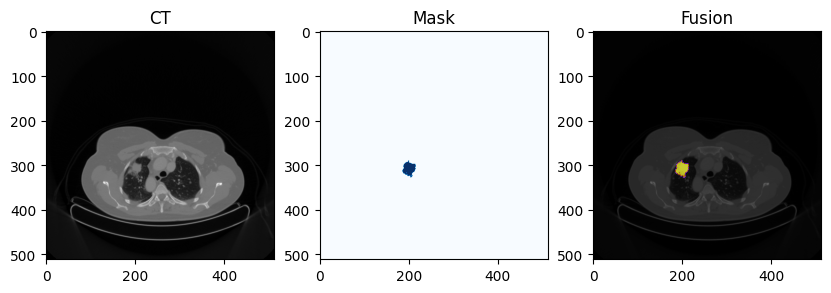

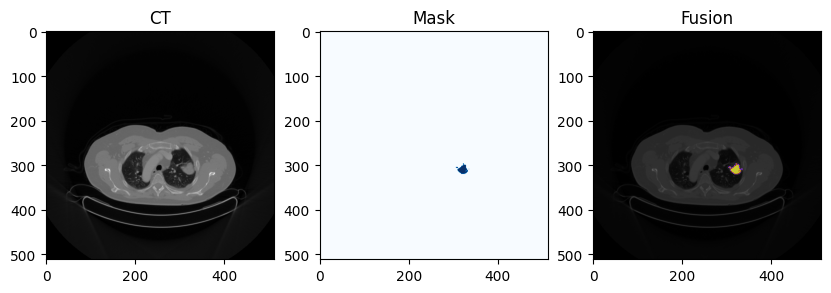

In [55]:
training_ds, testing_ds = get_training_testing_sm_datasets()


# Iterate through the training dataset
img_exam_train, mask_exam_train = None, None
img_exam_test, mask_exam_test = None, None
for patient_id, img_exam_train, mask_exam_train, label in training_ds:
    print("Patient ID:", patient_id.numpy().decode('utf-8'))
    print("Image Exam Shape:", img_exam_train.shape)
    print("Mask Exam Shape:", mask_exam_train.shape)
    print("Label:", label.numpy())
    break


# Iterate through the testing dataset
for patient_id, img_exam_test, mask_exam_test, label in testing_ds:
    print("Patient ID:", patient_id.numpy().decode('utf-8'))
    print("Image Exam Shape:", img_exam_test.shape)
    print("Mask Exam Shape:", mask_exam_test.shape)
    break


visualizeImgMask(img_exam_train, mask_exam_train, pet=False)
visualizeImgMask(img_exam_test, mask_exam_test, pet=False)

In [56]:
training_stanford, testing_stanford = get_training_testing_stanford_datasets()

# Iterate through the training dataset
stanford_img_exam_train, stanford_mask_exam_train = None, None
stanford_img_exam_test, stanford_mask_exam_test = None, None
for patient_id, stanford_img_exam_train, stanford_mask_exam_train, label in training_stanford:
    print("Patient ID:", patient_id.numpy().decode('utf-8'))
    print(stanford_img_exam_train)
    print("Image Exam Shape:", stanford_img_exam_train.shape)
    print("Mask Exam Shape:", stanford_mask_exam_train.shape)
    print("Label:", label.numpy())
    break


# Iterate through the testing dataset
for patient_id, stanford_img_exam_test, stanford_mask_exam_test, label in testing_stanford:
    print("Patient ID:", patient_id.numpy().decode('utf-8'))
    print("Image Exam Shape:", stanford_img_exam_test.shape)
    print("Mask Exam Shape:", stanford_mask_exam_test.shape)
    break


visualizeImgMask(stanford_img_exam_train, stanford_mask_exam_train, pet=False)
visualizeImgMask(stanford_img_exam_test, stanford_mask_exam_test, pet=False)

NameError: name 'stanford_info' is not defined

## Extraer el ROI de los examenes

In [58]:
def roiExtraction (img,mask,margin):
    """
  Función para extraer el ROI donde se encuentra el tumor en una imagen.
  INPUT: imagen y máscaras numpy array 2D.
  margin: corresponde al número de pixeles como margen por fuera de los pixeles de la máscara.
  OUTPUT: Devuelve el ROI.
  """

    roi_extract = []

    img_instance = img.numpy()
    mask_instance = mask.numpy()
    index = np.where(mask_instance)
    roi = img_instance[np.unique(index[0])[0]-margin:np.unique(index[0])[-1]+margin, np.unique(index[1])[0]-margin: np.unique(index[1])[-1]+margin]
    return roi


import numpy as np
from PIL import Image

def roiExtractionResize(img, mask, margin, size):
    """
    Función para extraer el ROI donde se encuentra el tumor en una imagen y redimensionar a un tamaño específico.
    INPUT: imagen y máscaras numpy array 2D.
    margin: corresponde al número de pixeles como margen por fuera de los píxeles de la máscara.
    size: tamaño al que se redimensionará el ROI (tupla de dos elementos: ancho y alto).
    OUTPUT: Devuelve el ROI redimensionado.
    """

    img_instance = img.numpy()
    mask_instance = mask.numpy()

    index = np.where(mask_instance)

    # Define the boundaries of the ROI
    y_min = np.maximum(np.unique(index[0])[0] - margin, 0)
    y_max = np.minimum(np.unique(index[0])[-1] + margin, img_instance.shape[0])
    x_min = np.maximum(np.unique(index[1])[0] - margin, 0)
    x_max = np.minimum(np.unique(index[1])[-1] + margin, img_instance.shape[1])

    # Extract the ROI
    roi = img_instance[y_min:y_max, x_min:x_max]

    # Resize the ROI using PIL and NumPy
    img_pil = Image.fromarray(roi)
    img_resized = img_pil.resize(size, Image.ANTIALIAS)
    roi_resized = np.array(img_resized)

    return roi_resized

    


def roiExtractionSize(img, mask, total_size):
    """
    Function to extract ROIs from images while ensuring a consistent total size for all ROIs.

    INPUT:
    img: Numpy array of images.
    mask: Numpy array of masks.
    total_size: The desired total size (width and height) of the extracted ROIs.

    OUTPUT: Numpy array containing the ROIs.
    """
    
    img_instance = img.numpy()
    mask_instance = mask.numpy()
    index = np.where(mask_instance)

    # Calculate the center of the mask.
    center_row = int(np.mean(index[0]))
    center_col = int(np.mean(index[1]))

    # Calculate the size of the ROI based on the total size.
    half_size = total_size // 2

    # Determine ROI boundaries with the margin.
    min_row = max(0, center_row - half_size)
    max_row = min(mask_instance.shape[0], center_row + half_size)
    min_col = max(0, center_col - half_size)
    max_col = min(mask_instance.shape[1], center_col + half_size)

    # Calculate the width and height of the ROI.
    roi_height = max_row - min_row
    roi_width = max_col - min_col

    # Case 1: If the ROI is smaller than the total_size, add a margin to make it total_size.
    if roi_height < total_size:
        margin = (total_size - roi_height) // 2
        min_row -= margin
        max_row += margin

    if roi_width < total_size:
        margin = (total_size - roi_width) // 2
        min_col -= margin
        max_col += margin

    # Case 2: If the ROI is larger than total_size, resize it.
    if roi_height > total_size or roi_width > total_size:
        scale_factor = total_size / max(roi_height, roi_width)
        new_height = int(roi_height * scale_factor)
        new_width = int(roi_width * scale_factor)
        min_row = max(center_row - new_height // 2, 0)
        max_row = min(min_row + new_height, mask_instance.shape[0])
        min_col = max(center_col - new_width // 2, 0)
        max_col = min(min_col + new_width, mask_instance.shape[1])

    # Extract the ROI with the desired size.
    roi = img_instance[min_row:max_row, min_col:max_col]

    return roi

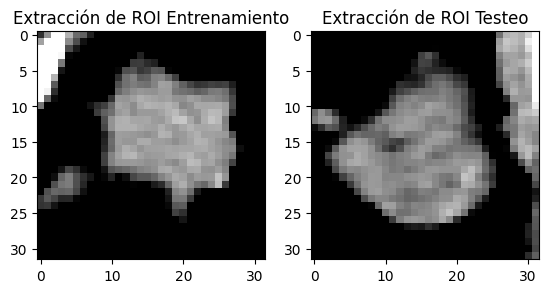

In [61]:
margin = 4
level = 50
window_width = 200
img_size = 64

#roi_exam_train = roiExtraction(img_exam_train, mask_exam_train, margin)
#roi_exam_test = roiExtraction(img_exam_test, mask_exam_test, margin)
roi_exam_train = roiExtractionSize(img_exam_train, mask_exam_train, 32)
roi_exam_test = roiExtractionSize(img_exam_test, mask_exam_test, 32)

f = plt.figure(figsize=(10,10), frameon=True)
f.add_subplot(1, 3, 1)
plt.title("Extracción de ROI Entrenamiento")
plt.imshow(show_slice_window(cv2.rotate(roi_exam_train,cv2.ROTATE_90_CLOCKWISE),level,window_width), cmap='gray')

f.add_subplot(1, 3, 2)
plt.title("Extracción de ROI Testeo")
plt.imshow(show_slice_window(cv2.rotate(roi_exam_test,cv2.ROTATE_90_CLOCKWISE),level,window_width), cmap='gray')

plt.show()


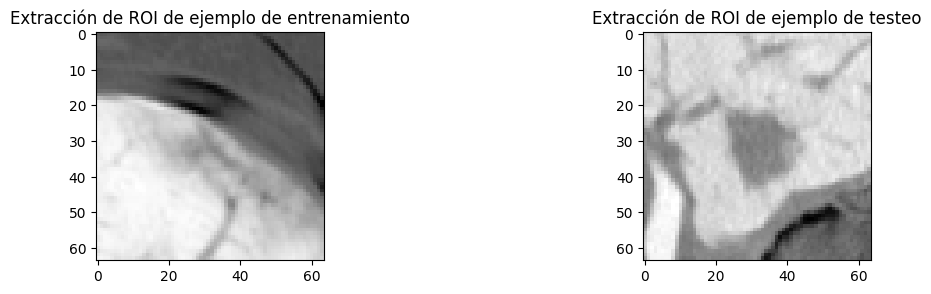

In [119]:
margin = 4
level = 50
window_width = 200
size = 64

stanford_roi_exam_train = roiExtractionSize(stanford_img_exam_train, stanford_mask_exam_train, size)
stanford_roi_exam_test = roiExtractionSize(stanford_img_exam_test, stanford_mask_exam_test, size)

f = plt.figure(figsize=(10, 10), frameon=True)
f.add_subplot(1, 3, 1)
plt.title("Extracción de ROI de ejemplo de entrenamiento")

# Correct usage of cv2.rotate()
# rotated_image = cv2.rotate(roi_exam_train, cv2.ROTATE_90_CLOCKWISE)

#print(roi_exam_train.shape)
# Assuming 'level' and 'window_width' are properly defined
# and you have a function show_slice_window to display the image with a specific window.
plt.imshow(stanford_roi_exam_train, cmap='gray_r')

f.add_subplot(1, 3, 3)
plt.title("Extracción de ROI de ejemplo de testeo")

# Assuming 'level' and 'window_width' are properly defined
# and you have a function show_slice_window to display the image with a specific window.
plt.imshow(stanford_roi_exam_test, cmap='gray_r')

## Implementación de K-Fold

Se implementa *K-Fold Stratified*. Esto es, con distribución de las clases balanceadas y aplicando el procesamiento de extracción de ROI.

In [ ]:
from sklearn.model_selection import StratifiedKFold


stanford_dataset, stanford_info = tfds.load('stanford_dataset/ct', with_info=True)
img_size = 64
def get_stratified_stanford_kfold_datasets(k=5, random_seed=None):
    '''Creates stratified k-fold cross-validation datasets with balanced class distribution.
    Returns a list of k pairs of training and testing datasets with balanced classes.'''
    
    # Set the random seed
    random.seed(random_seed)

    pos_patients = []
    neg_patients = []
    
    stanford_csv_file = Path('stanford_info_csv.csv')
    with stanford_csv_file.open() as f:
      for row in csv.DictReader(f):
        if row['EGFR mutation status'] == 'Mutant':
          pos_patients.append(row['Case ID'])
        else:
          neg_patients.append(row['Case ID'])

    # Get the split keys (splits) of the dataset
    split_keys = list(stanford_info.splits.keys())

    # Find positive and negative patients that are also in the split keys
    pos_patients = [patient for patient in pos_patients if patient in split_keys]
    neg_patients = [patient for patient in neg_patients if patient in split_keys]

    # Shuffle the order of positive and negative patients for randomness
    random.shuffle(pos_patients)
    random.shuffle(neg_patients)

    # Create labels for patients (1 for positive, 0 for negative)
    labels = [1] * len(pos_patients) + [0] * len(neg_patients)
    patients = pos_patients + neg_patients
    # Initialize stratified k-fold cross-validator
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=random_seed)

    fold_datasets = []
    
    for train_indices, test_indices in skf.split(patients, labels):
        training_patients = [patients[i] for i in train_indices]
        testing_patients = [patients[i] for i in test_indices]

        # Create dictionaries to hold the training and testing data
        training_data = {patient: stanford_dataset[patient] for patient in training_patients}
        testing_data = {patient: stanford_dataset[patient] for patient in testing_patients}

        # Create a generator for the training dataset
        def generate_training_data():
            for patient_id in training_patients:
                patient_data = training_data[patient_id]
                for data in patient_data:
                    mask_exam = data['mask_exam']
                    img_exam = data['img_exam']
                    roi_extract = roiExtractionSize(mask_exam, img_exam, img_size)
                    # Convert grayscale image (1 channel) to RGB (3 channels)
                    roi_extract_rgb = np.stack((roi_extract,) * 3, axis=2).astype(np.float32)
        
                    yield roi_extract_rgb, data['label']

        # Create a TensorFlow Dataset from the generator
        training_dataset = tf.data.Dataset.from_generator(
            generate_training_data,
            output_signature=(
                tf.TensorSpec(shape=(img_size, img_size, 3), dtype=tf.float32, name="imagen"),  # For mask_exam
                tf.TensorSpec(shape=(), dtype=tf.int64, name="label")  # For label
            )
        )

        # Create a generator for the testing dataset
        def generate_testing_data():
            for patient_id in testing_patients:
                patient_data = testing_data[patient_id]
                for data in patient_data:
                    mask_exam = data['mask_exam']
                    img_exam = data['img_exam']
                    roi_extract = roiExtractionSize(mask_exam, img_exam, img_size)
                    # Convert grayscale image (1 channel) to RGB (3 channels)
                    roi_extract_rgb = np.stack((roi_extract,) * 3, axis=2).astype(np.float32)
        
                    yield roi_extract_rgb, data['label']

        # Create a TensorFlow Dataset from the generator
        testing_dataset = tf.data.Dataset.from_generator(
            generate_testing_data,
            output_signature=(
                tf.TensorSpec(shape=(img_size, img_size, 3), dtype=tf.float32, name="imagen"),  # For mask_exam
                tf.TensorSpec(shape=(), dtype=tf.int64, name="label")  # For label
            )
        )

        fold_datasets.append((training_dataset, testing_dataset))

    return fold_datasets


In [ ]:
from sklearn.model_selection import StratifiedKFold


sample_dataset, info = tfds.load('santa_maria_dataset/body', with_info=True)
img_size = 64
def get_stratified_santamaria_kfold_datasets(k=5, random_seed=None):
    '''Creates stratified k-fold cross-validation datasets with balanced class distribution.
    Returns a list of k pairs of training and testing datasets with balanced classes.'''
    
    # Set the random seed
    random.seed(random_seed)

    pos_patients = []
    neg_patients = []
    
    stanford_csv_file = Path('stanford_info_csv.csv')
    with stanford_csv_file.open() as f:
      for row in csv.DictReader(f):
        if row['EGFR mutation status'] == 'Mutant':
          pos_patients.append(row['Case ID'])
        else:
          neg_patients.append(row['Case ID'])

    # Get the split keys (splits) of the dataset
    split_keys = list(stanford_info.splits.keys())

    # Find positive and negative patients that are also in the split keys
    pos_patients = [patient for patient in pos_patients if patient in split_keys]
    neg_patients = [patient for patient in neg_patients if patient in split_keys]

    # Shuffle the order of positive and negative patients for randomness
    random.shuffle(pos_patients)
    random.shuffle(neg_patients)

    # Create labels for patients (1 for positive, 0 for negative)
    labels = [1] * len(pos_patients) + [0] * len(neg_patients)
    patients = pos_patients + neg_patients
    # Initialize stratified k-fold cross-validator
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=random_seed)

    fold_datasets = []
    
    for train_indices, test_indices in skf.split(patients, labels):
        training_patients = [patients[i] for i in train_indices]
        testing_patients = [patients[i] for i in test_indices]

        # Create dictionaries to hold the training and testing data
        training_data = {patient: stanford_dataset[patient] for patient in training_patients}
        testing_data = {patient: stanford_dataset[patient] for patient in testing_patients}

        # Create a generator for the training dataset
        def generate_training_data():
            for patient_id in training_patients:
                patient_data = training_data[patient_id]
                for data in patient_data:
                    mask_exam = data['mask_exam']
                    img_exam = data['img_exam']
                    roi_extract = roiExtractionSize(mask_exam, img_exam, img_size)
                    # Convert grayscale image (1 channel) to RGB (3 channels)
                    roi_extract_rgb = np.stack((roi_extract,) * 3, axis=2).astype(np.float32)
        
                    yield roi_extract_rgb, data['label']

        # Create a TensorFlow Dataset from the generator
        training_dataset = tf.data.Dataset.from_generator(
            generate_training_data,
            output_signature=(
                tf.TensorSpec(shape=(img_size, img_size, 3), dtype=tf.float32, name="imagen"),  # For mask_exam
                tf.TensorSpec(shape=(), dtype=tf.int64, name="label")  # For label
            )
        )

        # Create a generator for the testing dataset
        def generate_testing_data():
            for patient_id in testing_patients:
                patient_data = testing_data[patient_id]
                for data in patient_data:
                    mask_exam = data['mask_exam']
                    img_exam = data['img_exam']
                    roi_extract = roiExtractionSize(mask_exam, img_exam, img_size)
                    # Convert grayscale image (1 channel) to RGB (3 channels)
                    roi_extract_rgb = np.stack((roi_extract,) * 3, axis=2).astype(np.float32)
        
                    yield roi_extract_rgb, data['label']

        # Create a TensorFlow Dataset from the generator
        testing_dataset = tf.data.Dataset.from_generator(
            generate_testing_data,
            output_signature=(
                tf.TensorSpec(shape=(img_size, img_size, 3), dtype=tf.float32, name="imagen"),  # For mask_exam
                tf.TensorSpec(shape=(), dtype=tf.int64, name="label")  # For label
            )
        )

        fold_datasets.append((training_dataset, testing_dataset))

    return fold_datasets


In [4]:
# Assuming you've loaded your data and defined your model as 'model'
from sklearn.model_selection import StratifiedKFold
from simple import SimpleModel

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Set the number of folds for cross-validation
sample_dataset, info = tfds.load('santa_maria_dataset/body', with_info=True)
img_size = 32
batch_size = 20


def get_training_testing_sm_datasets(split_val=0.8, random_seed=None):
    '''Crea particiones aleatorias de entrenamiento y testeo balancedas dada el split_val.
    Retorna dos conjuntos de datos, uno de entrenamiento y otro de testeo.'''

    # setea la semilla random
    random.seed(random_seed)

    # Define the positive and negative patients
    pos_patients = [f'sm_{str(i).zfill(3)}' for i in range(1, 13)]
    neg_patients = [f'sm_{str(i).zfill(3)}' for i in range(13, 36)]
    
    # Get the split keys (splits) of the dataset
    split_keys = list(info.splits.keys())

    # Find positive and negative patients that are also in the split keys
    pos_patients = [patient for patient in pos_patients if patient in split_keys]
    neg_patients = [patient for patient in neg_patients if patient in split_keys]
    
    # Shuffle the order of positive and negative patients for randomness
    random.shuffle(pos_patients)
    random.shuffle(neg_patients)
    
    # Calculate the number of patients for training and testing
    train_pos_count = int(split_val * len(pos_patients))
    train_neg_count = int(split_val * len(neg_patients))
    
    # Create the training and testing sets
    training_patients = pos_patients[:train_pos_count] + neg_patients[:train_neg_count]
    testing_patients = pos_patients[train_pos_count:] + neg_patients[train_neg_count:]
    
    # Create dictionaries to hold the training and testing data
    training_data = {patient: sample_dataset[patient] for patient in training_patients}
    testing_data = {patient: sample_dataset[patient] for patient in testing_patients}
    
    
    # Create a generator for the training dataset
    def generate_training_data():
        for patient_id in training_patients:
            patient_data = training_data[patient_id]
            for data in patient_data:
                mask_exam = data['mask_exam']
                img_exam = data['img_exam']
                roi_extract = roiExtractionSize(mask_exam, img_exam, img_size)
                # Convert grayscale image (1 channel) to RGB (3 channels)
                roi_extract_rgb = np.stack((roi_extract,) * 3, axis=2).astype(np.float32)
    
                yield roi_extract_rgb, data['label']
    
    # Create a TensorFlow Dataset from the generator
    training_dataset = tf.data.Dataset.from_generator(
        generate_training_data,
        output_signature=(
            tf.TensorSpec(shape=(img_size, img_size, 3), dtype=tf.float32, name="imagen"),  # For mask_exam
            tf.TensorSpec(shape=(), dtype=tf.int64, name="label")  # For label
            
        )
    )
    
    # Create a generator for the training dataset
    def generate_testing_data():
        for patient_id in testing_patients:
            patient_data = testing_data[patient_id]
            for data in patient_data:
                mask_exam = data['mask_exam']
                img_exam = data['img_exam']
                roi_extract = roiExtractionSize(mask_exam, img_exam, img_size)
                # Convert grayscale image (1 channel) to RGB (3 channels)
                roi_extract_rgb = np.stack((roi_extract,) * 3, axis=2).astype(np.float32)
    
                yield roi_extract_rgb, data['label']
    
    # Create a TensorFlow Dataset from the generator
    testing_dataset = tf.data.Dataset.from_generator(
            generate_testing_data,
            output_signature=(
                tf.TensorSpec(shape=(img_size, img_size, 3), dtype=tf.float32, name="imagen"),  # For mask_exam
                tf.TensorSpec(shape=(), dtype=tf.int64, name="label")  # For label
            )
        )

    return training_dataset, testing_dataset


# revisar imágenes antes de revisar
# visualizador que vaya mostrando el batch
# Get the stratified k-fold datasets
training_dataset, testing_dataset = get_training_testing_sm_datasets(random_seed=None)

training_dataset = training_dataset.batch(batch_size)
testing_dataset = testing_dataset.batch(batch_size)

# Create and compile your model for this fold
model = SimpleModel(1)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model on the training dataset for this fold
model.fit(training_dataset, epochs=40, validation_data=testing_dataset)

# Evaluate the model on the testing dataset for this fold
test_loss, test_accuracy = model.evaluate(testing_dataset)
print(f"Test accuracy for Fold: {test_accuracy}")




Epoch 1/40
15/15 [==============================] - 17s 866ms/step - loss: 0.7031 - accuracy: 0.3750 - val_loss: 0.6948 - val_accuracy: 0.5284
Epoch 2/40
15/15 [==============================] - 5s 311ms/step - loss: 0.6760 - accuracy: 0.3750 - val_loss: 0.7525 - val_accuracy: 0.5284
Epoch 3/40
15/15 [==============================] - 5s 307ms/step - loss: 0.6402 - accuracy: 0.3750 - val_loss: 0.8513 - val_accuracy: 0.5284
Epoch 4/40
15/15 [==============================] - 5s 312ms/step - loss: 0.6277 - accuracy: 0.3750 - val_loss: 1.0005 - val_accuracy: 0.5284
Epoch 5/40
15/15 [==============================] - 5s 349ms/step - loss: 0.6204 - accuracy: 0.3750 - val_loss: 1.1674 - val_accuracy: 0.5284
Epoch 6/40
15/15 [==============================] - 5s 294ms/step - loss: 0.6143 - accuracy: 0.3750 - val_loss: 1.3525 - val_accuracy: 0.5284
Epoch 7/40
15/15 [==============================] - 5s 340ms/step - loss: 0.6098 - accuracy: 0.3750 - val_loss: 1.5305 - val_accuracy: 0.5284
Epoch

In [ ]:
# Assuming you've loaded your data and defined your model as 'model'
from sklearn.model_selection import StratifiedKFold
from simple import SimpleModel

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Set the number of folds for cross-validation
k = 5
batch_size = 20

# Get the stratified k-fold datasets
fold_datasets = get_stratified_stanford_kfold_datasets(k=k, random_seed=None)

# Initialize lists to store the test accuracies from each fold
test_accuracies = []

for fold, (training_dataset, testing_dataset) in enumerate(fold_datasets):
    training_dataset = training_dataset.batch(batch_size)
    testing_dataset = testing_dataset.batch(batch_size)
    print(training_dataset)
    print(f"Fold {fold + 1}:")

    # Create and compile your model for this fold
    model = SimpleModel(1)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model on the training dataset for this fold
    model.fit(training_dataset, epochs=40, validation_data=testing_dataset)

    # Evaluate the model on the testing dataset for this fold
    test_loss, test_accuracy = model.evaluate(testing_dataset)
    test_accuracies.append(test_accuracy)
    print(f"Test accuracy for Fold {fold + 1}: {test_accuracy}")

# Calculate the mean and standard deviation of test accuracies over all folds
mean_test_accuracy = np.mean(test_accuracies)
std_test_accuracy = np.std(test_accuracies)

print(f"Mean Test Accuracy: {mean_test_accuracy}")
print(f"Standard Deviation of Test Accuracy: {std_test_accuracy}")
